In [1]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

# OSMNX Features

Ten notebook prezentuje możliwości wykorzystania OSMNX 

## Graf ulic


OSMnx geokoduje zapytanie "Wrocław, Poland", aby pobrać granice tego miasta z interfejsu API Nominatim, pobiera dane sieci ulic w tych granicach z interfejsu API Overpass, konstruuje model grafu, a następnie upraszcza / koryguje jego topologię w taki sposób, że węzły reprezentują skrzyżowania i ślepe zaułki, a krawędzie reprezentują łączące je odcinki ulic. 

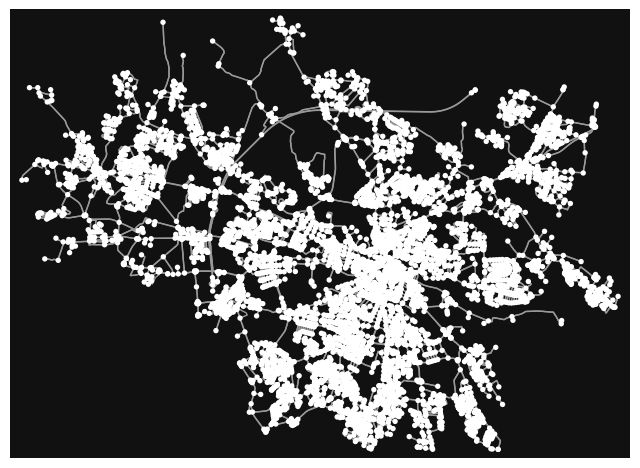

In [2]:
G = ox.graph_from_place("Wrocław, Poland", network_type="drive") # typ nx.MultiDiGraph lub None
fig, ax = ox.plot_graph(G)


In [3]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()  # type: ignore

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
95584835,51.083111,17.049513,4,NaN,NaN,POINT (17.04951 51.08311)
95584841,51.084699,17.064367,3,NaN,NaN,POINT (17.06437 51.08470)
95584850,51.083328,17.035057,4,NaN,NaN,POINT (17.03506 51.08333)
95584852,51.083009,17.053573,4,NaN,NaN,POINT (17.05357 51.08301)
95584855,51.083333,17.034685,4,NaN,NaN,POINT (17.03468 51.08333)


In [4]:
gdf_edges.head()  # type: ignore

osmid  oneway lanes  \
u        v         key                                        
95584835 297779709 0    [24707867, 656793686]    True     2   
         241778108 0    [656794402, 28458110]    True     2   
95584841 164895026 0                 27665976   False   NaN   
         268480775 0                304583916    True     2   
95584850 95584855  0                 28458082    True     3   

                                              name       highway maxspeed  \
u        v         key                                                      
95584835 297779709 0                       Bardzka      tertiary       50   
         241778108 0          Aleja Armii Krajowej       primary       50   
95584841 164895026 0    Biskupa Bernarda Bogedaina  unclassified      NaN   
         268480775 0          Aleja Armii Krajowej       primary       50   
95584850 95584855  0          Aleja Armii Krajowej       primary       50   

                       reversed   length  \
u        v         key                     
95584835 297779709 0      False  178.450   
         241778108 0      False   30.730   
95584841 164895026 0      False   14.714   
         268480775 0      False  125.913   
95584850 95584855  0      False   25.991   

                                                                 geometry  \
u        v         key                                                      
95584835 297779709 0    LINESTRING (17.04951 51.08311, 17.04947 51.083...   
         241778108 0    LINESTRING (17.04951 51.08311, 17.04933 51.083...   
95584841 164895026 0    LINESTRING (17.06437 51.08470, 17.06450 51.08460)   
         268480775 0    LINESTRING (17.06437 51.08470, 17.06412 51.084...   
95584850 95584855  0    LINESTRING (17.03506 51.08333, 17.03468 51.08333)   

                        ref access bridge junction width tunnel  
u        v         key                                           
95584835 297779709 0    NaN    NaN    NaN      NaN   NaN    NaN  
         241778108 0     94    NaN    NaN      NaN   NaN    NaN  
95584841 164895026 0    NaN    NaN    NaN      NaN   NaN    NaN  
         268480775 0     94    NaN    NaN      NaN   NaN    NaN  
95584850 95584855  0     94    NaN    NaN      NaN   NaN    NaN

Można też stworzyć graf z node/edge gdf dopóki wierzchołki są indeksowane przez osmid a krawędzie są multi indeksowane przez y, v, key (struktura MultiDiGraph).

In [5]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

### Statystyki

In [6]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area # type: ignore
graph_area_m

319240693.8519159

In [7]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 7169,
 'm': 16873,
 'k_avg': 4.707211605523783,
 'edge_length_total': 2394325.5450000144,
 'edge_length_avg': 141.90277632904727,
 'streets_per_node_avg': 2.775561445110894,
 'streets_per_node_counts': {0: 0,
  1: 1240,
  2: 134,
  3: 4837,
  4: 913,
  5: 43,
  6: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1729669409959548,
  2: 0.018691588785046728,
  3: 0.6747105593527689,
  4: 0.12735388478169898,
  5: 0.005998047147440368,
  6: 0.0002789789370902497},
 'intersection_count': 5929,
 'street_length_total': 1378766.5179999976,
 'street_segment_count': 9930,
 'street_length_avg': 138.848591943605,
 'circuity_avg': 1.049298193098589,
 'self_loop_proportion': 0.0028197381671701913,
 'clean_intersection_count': 4482,
 'node_density_km': 22.456410282473062,
 'intersection_density_km': 18.57219369016359,
 'edge_density_km': 7500.063717160865,
 'street_density_km': 4318.893375916408,
 'clean_intersection_density_km': 14.039563521557298}

In [8]:
# street centrality
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

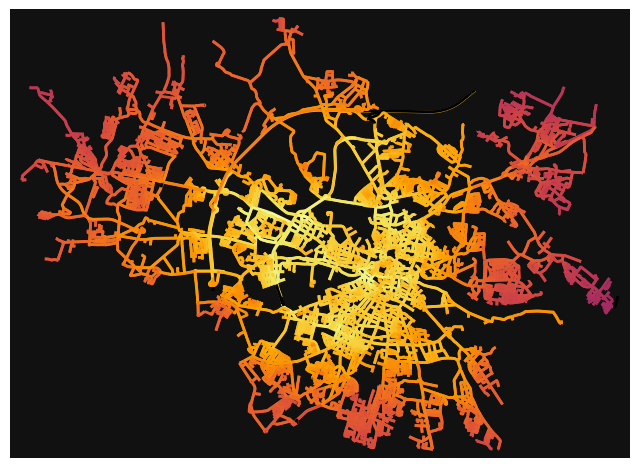

In [9]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno") # type: ignore
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

### Routing

OSMNX pozwala na znajdowanie najkrótszej trasy pomiędzy wierzchołkami, określanie długości drogi, czy też wysopkości (elevation)

NOTE: Elevation może być realizowane poprzez odpowiedni lokalny plik lub [Google Maps Elevation API](https://developers.google.com/maps/documentation/elevation/overview?hl=pl) (potrzebny klucz)

In [10]:
# impute missing edge speeds and calculate edge travel times with the speed module 
# (https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.speed.add_edge_speeds)
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [11]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges

osmid  oneway lanes  \
u           v          key                                           
95584835    297779709  0       [24707867, 656793686]    True     2   
            241778108  0       [656794402, 28458110]    True     2   
95584841    164895026  0                    27665976   False   NaN   
            268480775  0                   304583916    True     2   
95584850    95584855   0                    28458082    True     3   
...                                              ...     ...   ...   
11219422358 9429542220 0    [1207115442, 1210930875]   False   NaN   
11315118536 4084010776 0                   406316282   False   NaN   
11352506799 5894904107 0      [378490349, 745309237]   False   NaN   
            6976675773 0                   745309237   False   NaN   
            9121881278 0                  1223946531    True   NaN   

                                                  name        highway  \
u           v          key                                              
95584835    297779709  0                       Bardzka       tertiary   
            241778108  0          Aleja Armii Krajowej        primary   
95584841    164895026  0    Biskupa Bernarda Bogedaina   unclassified   
            268480775  0          Aleja Armii Krajowej        primary   
95584850    95584855   0          Aleja Armii Krajowej        primary   
...                                                ...            ...   
11219422358 9429542220 0                           NaN    residential   
11315118536 4084010776 0                      Jeżowska    residential   
11352506799 5894904107 0              Beaty Artemskiej    residential   
            6976675773 0              Beaty Artemskiej    residential   
            9121881278 0                           NaN  living_street   

                           maxspeed reversed   length  \
u           v          key                              
95584835    297779709  0         50    False  178.450   
            241778108  0         50    False   30.730   
95584841    164895026  0        NaN    False   14.714   
            268480775  0         50    False  125.913   
95584850    95584855   0         50    False   25.991   
...                             ...      ...      ...   
11219422358 9429542220 0        NaN    False  316.729   
11315118536 4084010776 0        NaN    False   47.364   
11352506799 5894904107 0        NaN    False  140.111   
            6976675773 0        NaN     True   87.326   
            9121881278 0        NaN    False  119.830   

                                                                     geometry  \
u           v          key                                                      
95584835    297779709  0    LINESTRING (17.04951 51.08311, 17.04947 51.083...   
            241778108  0    LINESTRING (17.04951 51.08311, 17.04933 51.083...   
95584841    164895026  0    LINESTRING (17.06437 51.08470, 17.06450 51.08460)   
            268480775  0    LINESTRING (17.06437 51.08470, 17.06412 51.084...   
95584850    95584855   0    LINESTRING (17.03506 51.08333, 17.03468 51.08333)   
...                                                                       ...   
11219422358 9429542220 0    LINESTRING (17.10463 51.14458, 17.10467 51.144...   
11315118536 4084010776 0    LINESTRING (16.90342 51.14250, 16.90407 51.14238)   
11352506799 5894904107 0    LINESTRING (17.05234 51.05584, 17.05298 51.055...   
            6976675773 0    LINESTRING (17.05234 51.05584, 17.05233 51.055...   
            9121881278 0    LINESTRING (17.05234 51.05584, 17.05233 51.055...   

                            edge_centrality  speed_kph  travel_time  ref  \
u           v          key                                                 
95584835    297779709  0           0.022291       50.0         12.8  NaN   
            241778108  0           0.022290       50.0          2.2   94   
95584841    164895026  0           0.021688       36.6          1.4  NaN   
          

Jak widać wyżej pojawiły się atrybuty krawędzi takie jak travel_time czy speed

## Inne typy sieci

In [12]:
"""
network_type : string {"all_private", "all", "bike", "drive", "drive_service", "walk"}
        what type of street network to get if custom_filter is None
custom_filter : string
        a custom ways filter to be used instead of the network_type presets
        e.g., '["power"~"line"]' or '["highway"~"motorway|trunk"]'. Also pass
        in a network_type that is in settings.bidirectional_network_types if
        you want graph to be fully bi-directional.

 UWAGA - custom_filter musi być jakąś siecią (amenity np. nie każde działa)
"""
cf = '["building"~"residential"]'
G = ox.graph_from_place("Wrocław, Poland", network_type="all", custom_filter=cf)
len(G)

34

In [13]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head() 

,y,x,street_count,geometry
osmid,,,,
6239391508,51.047053,17.026246,4,POINT (17.02625 51.04705)
6239391509,51.047076,17.026064,4,POINT (17.02606 51.04708)
6239391510,51.047116,17.026292,4,POINT (17.02629 51.04712)
6239391511,51.047145,17.026064,4,POINT (17.02606 51.04714)
1164364310,51.046984,17.026250,4,POINT (17.02625 51.04698)


In [14]:
gdf_edges.head()

osmid  oneway  reversed  length  \
u          v          key                                        
6239391508 6239391509 0    264895720   False     False  12.939   
                      1    666427880   False      True  12.939   
           6239391510 0    264895720   False      True   9.226   
           1164364310 0    666427880   False     False   9.287   
6239391509 6239391508 0    264895720   False      True  12.939   

                                                                    geometry  
u          v          key                                                     
6239391508 6239391509 0    LINESTRING (17.02625 51.04705, 17.02606 51.04708)  
                      1    LINESTRING (17.02625 51.04705, 17.02606 51.04708)  
           6239391510 0    LINESTRING (17.02625 51.04705, 17.02626 51.047...  
           1164364310 0    LINESTRING (17.02625 51.04705, 17.02623 51.047...  
6239391509 6239391508 0    LINESTRING (17.02606 51.04708, 17.02625 51.04705)

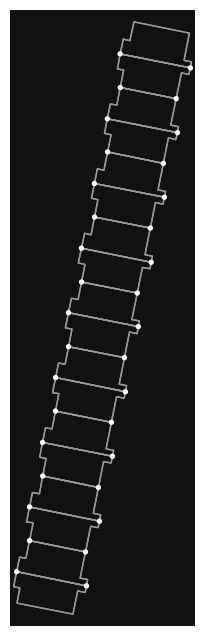

In [15]:
fig, ax = ox.plot_graph(G)

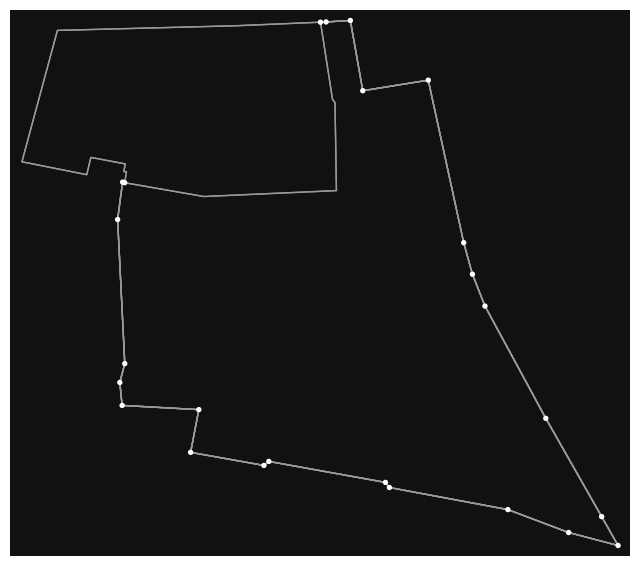

In [16]:
cf = '["amenity"~"school"]'
G3 = ox.graph_from_place("Wrocław, Poland", network_type="all", custom_filter=cf)
fig, ax = ox.plot_graph(G3)

In [17]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G3)
gdf_nodes.head() 

,y,x,street_count,geometry
osmid,,,,
5455005701,51.106097,17.093695,4,POINT (17.09370 51.10610)
5455005702,51.106102,17.093832,4,POINT (17.09383 51.10610)
5455005703,51.105853,17.093902,4,POINT (17.09390 51.10585)
5455005704,51.105890,17.094272,4,POINT (17.09427 51.10589)
5455005705,51.105089,17.094592,4,POINT (17.09459 51.10509)


In [18]:
gdf_edges

osmid                               name  \
u          v          key                                                  
5455005701 3833463378 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
           5455005702 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
5455005702 5455005701 0     569017499            Szkoła Podstawowa nr 66   
...                               ...                                ...   
3833463378 3833463366 1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
4315060592 5455005704 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
           3896780344 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   

                             landuse  oneway  reversed   length  \
u          v          key                                         
5455005701 3833463378 0    education   False     False    2.208   
                      1    education   False      True    2.208   
           5455005702 0    education   False      True    9.582   
                      1    education   False     False    9.582   
5455005702 5455005701 0    education   False     False    9.582   
...                              ...     ...       ...      ...   
3833463378 3833463366 1    education   False      True  212.811   
4315060592 5455005704 0    education   False     False   65.565   
                      1    education   False      True   65.565   
           3896780344 0    education   False      True   12.910   
                      1    education   False     False   12.910   

                                                                    geometry  
u          v          key                                                     
5455005701 3833463378 0    LINESTRING (17.09370 51.10610, 17.09366 51.10610)  
                      1    LINESTRING (17.09370 51.10610, 17.09366 51.10610)  
           5455005702 0    LINESTRING (17.09370 51.10610, 17.09383 51.10610)  
                      1    LINESTRING (17.09370 51.10610, 17.09383 51.10610)  
5455005702 5455005701 0    LINESTRING (17.09383 51.10610, 17.09370 51.10610)  
...                                                                      ...  
3833463378 3833463366 1    LINESTRING (17.09366 51.10610, 17.09318 51.106...  
4315060592 5455005704 0    LINESTRING (17.09447 51.10531, 17.09427 51.10589)  
                      1    LINESTRING (17.09447 51.10531, 17.09427 51.10589)  
           3896780344 0    LINESTRING (17.09447 51.10531, 17.09452 51.10520)  
                      1    LINESTRING (17.09447 51.10531, 17.09452 51.10520)  

[100 rows x 7 columns]

Nie jestem w stanie dokładnie powiedzieć w jaki sposób wyznaczany jest graf dla innych atrybutów niż te reprezentujące sieć dróg, kanalizacji itp. jednak na podstawie powyższych przykładów można powiedzieć, że brane jest otoczenie wokół danego obiektu, jak przykłąd wyżej otoczenie szkoły na Sępolnie. Ale dlaczego na Sępolnie? Dlaczego za każdym razem jest to ta sama szkoła? Nie mam pojęcia.


Sprawdźmy bardziej basicowy przypadek jakim jest '["highway"~"primary"]'

In [19]:
cf = '["highway"~"primary"]'
G = ox.graph_from_place("Wrocław, Poland", network_type="all", custom_filter=cf)
print(len(G), "primary")

113 primary


In [20]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head() 

osmid  \
u         v          key                                                      
150597420 150597432  0                                             53214063   
150597432 151024787  0                                             53214062   
          2433081746 0    [32798113, 32798115, 1159841445, 1159841446, 2...   
151024787 151024817  0                                             22664287   
151024817 150597420  0                                            173903958   

                          oneway      lanes   ref  \
u         v          key                            
150597420 150597432  0      True          3  5;94   
150597432 151024787  0      True          4   NaN   
          2433081746 0      True  [2, 3, 4]  5;94   
151024787 151024817  0      True          3  5;94   
151024817 150597420  0      True          3   NaN   

                                                   name  highway maxspeed  \
u         v          key                                                    
150597420 150597432  0                              FAT  primary       50   
150597432 151024787  0                              FAT  primary       50   
          2433081746 0    Aleja Generała Józefa Hallera  primary       50   
151024787 151024817  0                              FAT  primary       50   
151024817 150597420  0                              FAT  primary       50   

                         reversed    length  \
u         v          key                      
150597420 150597432  0      False    26.654   
150597432 151024787  0      False    24.572   
          2433081746 0      False  2437.636   
151024787 151024817  0      False    27.575   
151024817 150597420  0      False    23.477   

                                                                   geometry  \
u         v          key                                                      
150597420 150597432  0    LINESTRING (16.97963 51.09464, 16.97978 51.094...   
150597432 151024787  0    LINESTRING (16.97984 51.09444, 16.98018 51.09450)   
          2433081746 0    LINESTRING (16.97984 51.09444, 16.97996 51.094...   
151024787 151024817  0    LINESTRING (16.98018 51.09450, 16.98010 51.094...   
151024817 150597420  0    LINESTRING (16.97995 51.09470, 16.97963 51.09464)   

                         bridge junction access  
u         v          key                         
150597420 150597432  0      NaN      NaN    NaN  
150597432 151024787  0      NaN      NaN    NaN  
          2433081746 0      NaN      NaN    NaN  
151024787 151024817  0      NaN      NaN    NaN  
151024817 150597420  0      NaN      NaN    NaN

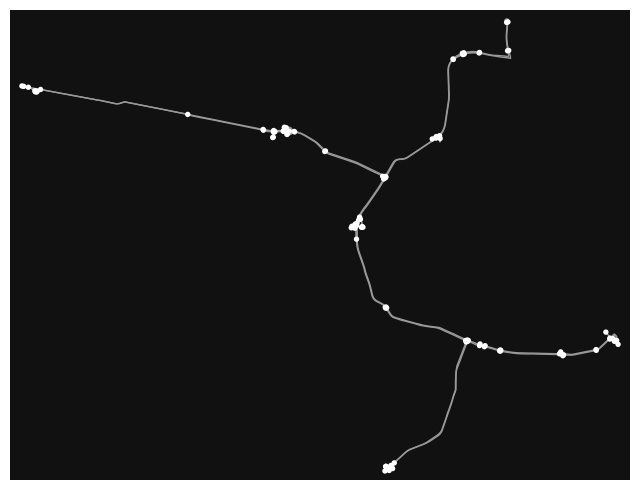

In [21]:
fig, ax = ox.plot_graph(G)

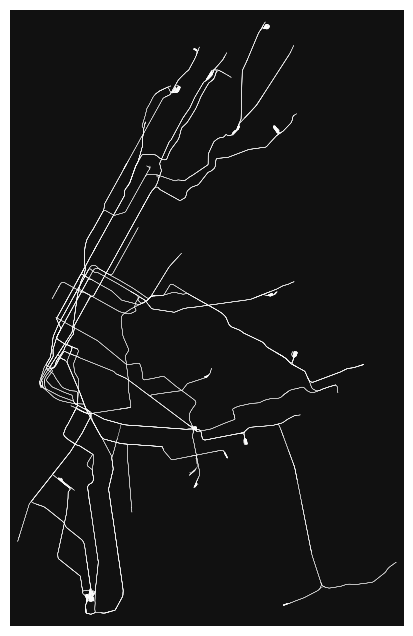

In [22]:
# get NY subway rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should download a station adjacency matrix elsewhere
ox.settings.useful_tags_way += ["railway"]
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

In [23]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head() 

osmid  \
u        v          key                                                      
42507216 3514377668 0                                            344690669   
         3514445036 0                                            813273119   
         1413569906 0    [344659072, 344623108, 344620812, 344621709, 3...   
42795301 2946920015 0    [46892613, 46892614, 46892617, 46892622, 46892...   
         42795313   0                                              5700312   

                           service railway  oneway reversed    length  \
u        v          key                                                 
42507216 3514377668 0    crossover  subway   False     True    65.292   
         3514445036 0          NaN  subway   False    False    25.108   
         1413569906 0          NaN  subway   False     True  5749.956   
42795301 2946920015 0          NaN  subway   False    False   866.908   
         42795313   0          NaN  subway   False     True  1056.558   

                                      name tunnel bridge  \
u        v          key                                    
42507216 3514377668 0                  NaN    NaN    NaN   
         3514445036 0    BMT Brighton Line    NaN    NaN   
         1413569906 0    BMT Brighton Line    yes    yes   
42795301 2946920015 0    IND Rockaway Line    NaN    yes   
         42795313   0    IND Rockaway Line    NaN    NaN   

                                                                  geometry  \
u        v          key                                                      
42507216 3514377668 0    LINESTRING (-73.96163 40.65839, -73.96149 40.6...   
         3514445036 0    LINESTRING (-73.96163 40.65839, -73.96166 40.6...   
         1413569906 0    LINESTRING (-73.96163 40.65839, -73.96136 40.6...   
42795301 2946920015 0    LINESTRING (-73.82962 40.65922, -73.82970 40.6...   
         42795313   0    LINESTRING (-73.82962 40.65922, -73.82931 40.6...   

                        maxspeed  
u        v          key           
42507216 3514377668 0        NaN  
         3514445036 0        NaN  
         1413569906 0        NaN  
42795301 2946920015 0        NaN  
         42795313   0        NaN

## Cechy przestrzenne (obiekty)

In [24]:
# get all building footprints in some neighborhood
place = "Wrocław, Poland"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

(148318, 436)

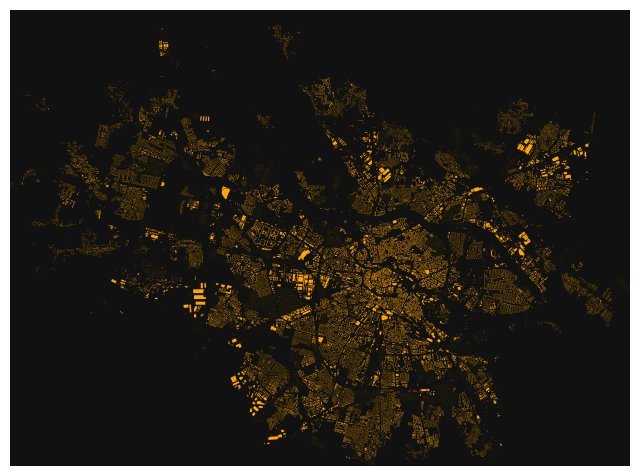

In [25]:
fig, ax = ox.plot_footprints(gdf)

In [26]:
gdf

entrance level  \
element_type osmid                        
node         7552223064       NaN   NaN   
             9704194694       NaN   NaN   
             10001401486      NaN   NaN   
             10965056566      NaN   NaN   
             10965056567      NaN   NaN   
...                           ...   ...   
relation     15395438         NaN   NaN   
             15602205         NaN   NaN   
             15852014         NaN   NaN   
             15852015         NaN   NaN   
             16291071         NaN   NaN   

                                                                   geometry  \
element_type osmid                                                            
node         7552223064                           POINT (16.97494 51.19952)   
             9704194694                           POINT (16.99264 51.15054)   
             10001401486                          POINT (17.12710 51.15119)   
             10965056566                          POINT (17.02263 51.04969)   
             10965056567                          POINT (17.02243 51.04918)   
...                                                                     ...   
relation     15395438     POLYGON ((16.97894 51.09333, 16.97894 51.09331...   
             15602205     POLYGON ((17.05676 51.12539, 17.05677 51.12539...   
             15852014     POLYGON ((17.06037 51.11596, 17.06040 51.11608...   
             15852015     POLYGON ((17.06035 51.11612, 17.06036 51.11614...   
             16291071     POLYGON ((17.00758 51.11262, 17.00805 51.11257...   

                            amenity capacity  fee artist_name artwork_type  \
element_type osmid                                                           
node         7552223064         NaN      NaN  NaN         NaN          NaN   
             9704194694         NaN      NaN  NaN         NaN          NaN   
             10001401486  fast_food      NaN  NaN         NaN          NaN   
             10965056566        NaN      NaN  NaN         NaN          NaN   
             10965056567        NaN      NaN  NaN         NaN          NaN   
...                             ...      ...  ...         ...          ...   
relation     15395438           NaN      NaN  NaN         NaN          NaN   
             15602205           NaN      NaN  NaN         NaN          NaN   
             15852014           NaN      NaN  NaN         NaN          NaN   
             15852015           NaN      NaN  NaN         NaN          NaN   
             16291071           NaN      NaN  NaN         NaN          NaN   

                         brand:wikidata brand:wikipedia  ... toilets:fee  \
element_type osmid                                       ...               
node         7552223064             NaN             NaN  ...         NaN   
             9704194694             NaN             NaN  ...         NaN   
             10001401486            NaN             NaN  ...         NaN   
             10965056566            NaN             NaN  ...         NaN   
             10965056567            NaN             NaN  ...         NaN   
...                                 ...             ...  ...         ...   
relation     15395438               NaN             NaN  ...         NaN   
             15602205               NaN             NaN  ...         NaN   
             15852014               NaN             NaN  ...         NaN   
             15852015               NaN             NaN  ...         NaN   
             16291071               NaN             NaN  ...         NaN   

                         kids_area service:electricity clothes  \
element_type osmid                                               
node         7552223064        NaN                 NaN     NaN   
             9704194694        NaN                 NaN     NaN   
             10001401486       NaN                 NaN     NaN   
             10965056566       NaN                 NaN     NaN   
             10965056567       NaN   

In [27]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape

(1782, 92)

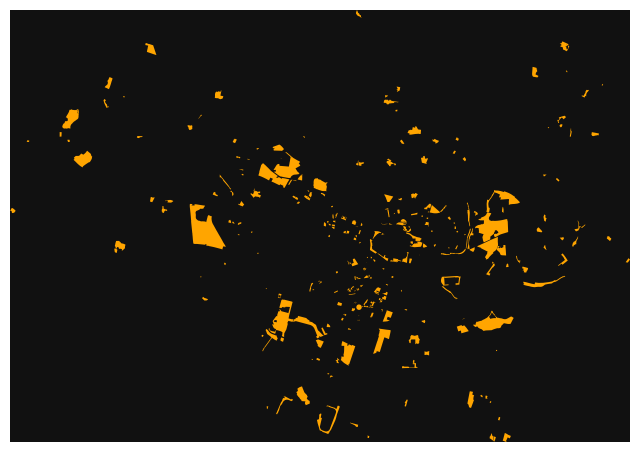

In [28]:
fig, ax = ox.plot_footprints(gdf)

Jeśli mamy odpowiednie gdf spełniające [wymagania](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.utils_graph.graph_from_gdfs) można samodzielnie utworzyć graf z wierzchołków i krawędzi za pomocą **osmnx.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=None)**

## Mapy izochroniczne 
**Jak daleko można dojść pieszo w ciągu 15min we Wrocławiu?**

Mapy izochroniczne reprezentują "mapę ciepła" odnośnie określonego zjawiska, jak np. wyżej wspomiane dojście pieszo od centrum sieci.

In [29]:
# configure the place, network type, trip times, and travel speed
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
travel_speed = 4.5  # walking speed in km/hour
G = ox.graph_from_place("Wrocław, Poland", network_type=network_type)

In [30]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

In [31]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [32]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

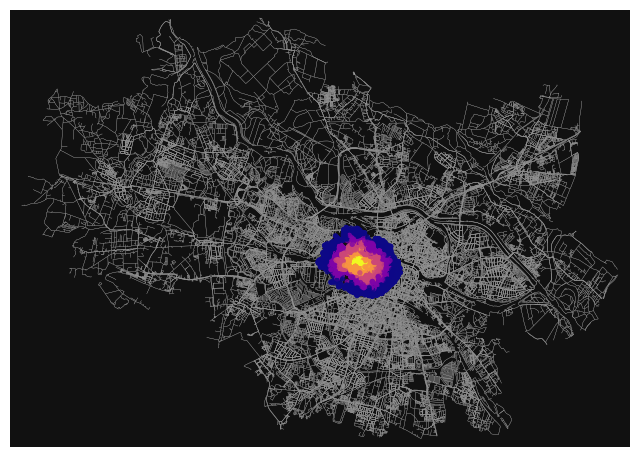

In [33]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

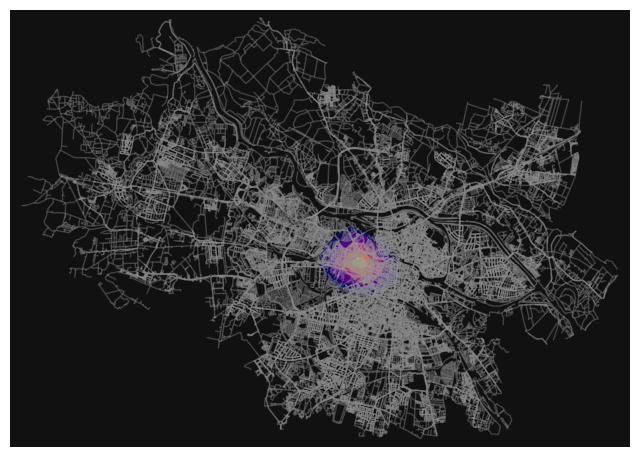

In [34]:
import matplotlib.pyplot as plt
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

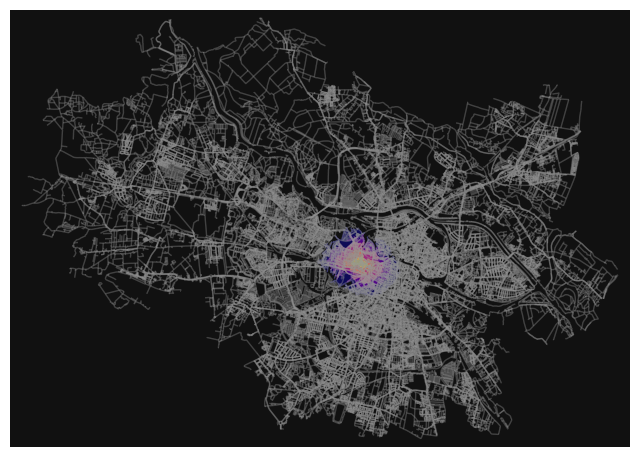

In [35]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

## Query na podstawie daty

[tutaj](https://geoffboeing.com/2020/06/whats-new-with-osmnx/)

In [39]:
place = "Wroclaw, Poland"
cs = '[out:json][timeout:180][date:"2019-10-28T19:20:00Z"]'
gdf = ox.features_from_poi(place, tags={"amenity": "school"}, custom_settings=cs)
gdf.head()

AttributeError: module 'osmnx' has no attribute 'features_from_poi'

## R-tree spatial indexing
[tutaj](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/ )

## Network-based spatial clustering 

[tutaj](https://geoffboeing.com/2018/04/network-based-spatial-clustering/)

# Wyznaczanie trasy pieszej pomiędzy 2 punktami! ---> jakieś api na openstreetmap

* Graphhopper 
* OSRM
* Valhalla




## Podsumowanie

* OSMNX pozwala na proste tworzenie i eksplorację grafów na danych przestrzennych. 
* Domyślnym targetem są grafy ulic 
* Istnieje możliwość samodzielnego zdefiniowania grafu przy odpowiednim zdefiniowaniu wierzchołków i krawędzi
* OSMNX udostępnia możliwość tworzenia gdf cech dla zadanego query z zadanego miejsca
